# Modelling and Predicting Employee Attrition #

In [8]:
library(tidyverse)
library(broom)
library(GGally)
library(car)
library(glmnet)
library(caret)
library(repr)
library(infer)
library(gridExtra)
library(pROC)
library(boot)
install.packages("ROSE")
options(warn = -1)
library(ROSE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## STAT 301: Planning Stage

#### Names: Justin Bourdon, Nour Abdelfattah, Nav Thukral

#### Student Numbers: 13755392, 97158414, 20761581

## Introduction

In [9]:
# Download latest version
path = "HR-Employee-Attrition 2.csv"

data=read_csv(path)

head(data)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


## Methods and Results ## 

### 1) EDA ###

### 2) Methods: Plan ###

In [10]:
attrition_data <- data

attrition_data <- attrition_data %>%
  mutate(
    JobSatisfaction = as.factor(JobSatisfaction),
    Attrition = if_else(Attrition == "Yes", 1, 0) 
  )

table(attrition_data$Attrition)


   0    1 
1233  237 

In [11]:
set.seed(123)

attrition_data <- attrition_data %>%
  mutate(ID = row_number())

#training set
attrition_data_train <- 
    attrition_data %>% 
    slice_sample(prop = 0.70)

#test set 
attrition_data_test <- 
    attrition_data %>% 
    anti_join(attrition_data_train, by = "ID")

cat("Training Set Class Distribution:\n")
print(table(attrition_data_train$Attrition))

cat("\nTest Set Class Distribution:\n")
print(table(attrition_data_test$Attrition))

#oversampling minority class in training set to adjust class imbalance issue
balanced_data_train <- ovun.sample(
    Attrition ~ ., 
    data = attrition_data_train, 
    method = "both", 
    p = 0.3 # Proportion of the minority class you (30%)
)$data

cat("\nBalanced Training Set Class Distribution:\n")
table(balanced_data_train$Attrition)

attrition_data_train <- balanced_data_train  %>% select(-ID)
attrition_data_test <- attrition_data_test  %>% select(-ID)

Training Set Class Distribution:

  0   1 
867 162 

Test Set Class Distribution:

  0   1 
366  75 

Balanced Training Set Class Distribution:



  0   1 
726 303 

In [12]:
#additive model 
logistic_model <- 
    glm(
        formula = Attrition ~ MonthlyIncome + YearsAtCompany + JobSatisfaction,
        data = attrition_data_train,
        family = binomial)

# 10-fold cross-validation
cv_results <- cv.glm(
    data = attrition_data_train, 
    glmfit = logistic_model,
    K = 10
)

# cross-validated error
print(cv_results$delta[1])  # Cross-validation errors


[1] 0.1882144


In [13]:
#predict attrition class on test set
pred_classes <- 
  round(predict(logistic_model, newdata = attrition_data_test, type = "response"),0)

#illustarte results in confusion matrix
attrition_data_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(pred_classes),
    reference = as.factor(attrition_data_test$Attrition),
    positive = '1'
)


attrition_data_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 345  65
         1  21  10
                                          
               Accuracy : 0.805           
                 95% CI : (0.7649, 0.8409)
    No Information Rate : 0.8299          
    P-Value [Acc > NIR] : 0.9255          
                                          
                  Kappa : 0.0991          
                                          
 Mcnemar's Test P-Value : 3.538e-06       
                                          
            Sensitivity : 0.13333         
            Specificity : 0.94262         
         Pos Pred Value : 0.32258         
         Neg Pred Value : 0.84146         
             Prevalence : 0.17007         
         Detection Rate : 0.02268         
   Detection Prevalence : 0.07029         
      Balanced Accuracy : 0.53798         
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC Value: 0.54 


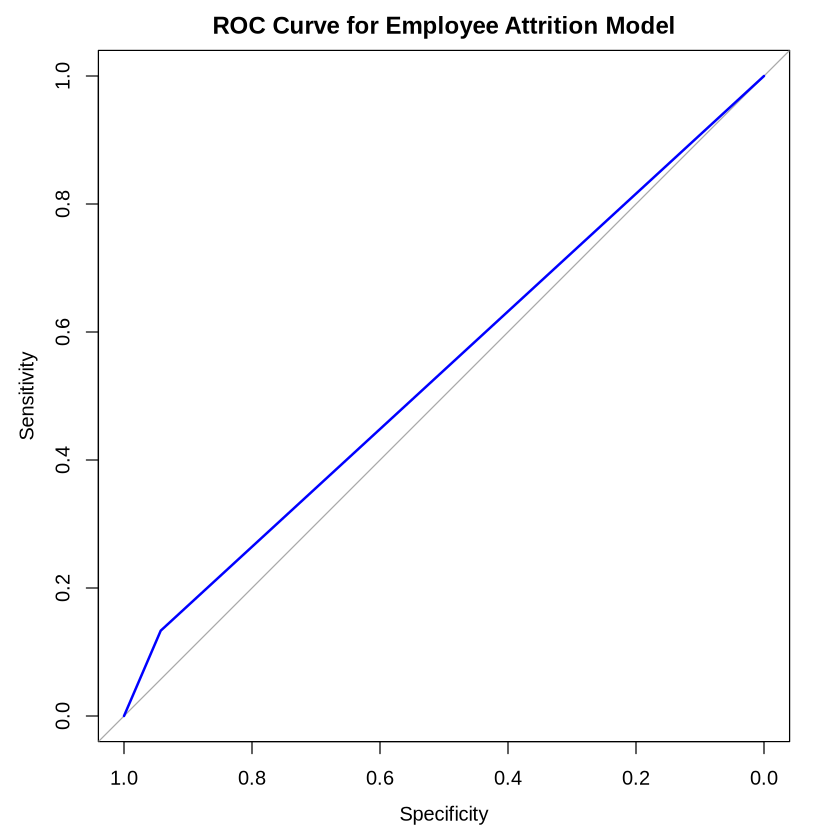

In [14]:
# Generate the ROC curve
roc_curve <- roc(response = attrition_data_test$Attrition, 
                 predictor = pred_classes)

# Plot the ROC curve
plot(roc_curve, 
     main = "ROC Curve for Employee Attrition Model", 
     col = "blue", 
     lwd = 2)

# Add AUC to the plot
auc_value <- auc(roc_curve)
cat("AUC Value:", round(auc_value, 2), "\n")


## Discussion ##

## References ## 